# Clase Práctica # 8 (Compilación)

En esta clase estaremos implementando un **intérprete de expresiones regulares**. Utilizaremos autómatas finitos como mecanismo reconocedor del lenguaje que denota cada expresión regular. Nos apoyaremos en las operaciones entre autómatas implementadas en las clases anteriores para ello.

In [1]:
from cmp.tools.automata import NFA, DFA, nfa_to_dfa
from cmp.tools.automata import automata_union, automata_concatenation, automata_closure, automata_minimization

## Expresiones regulares

Evaluar una expresión de determinado dominio no debería parecernos un problema salido de la nada. Desde comienzos del curso, y hasta unas clases atrás, estuvimos enfrentándonos al problema de evaluar expresiones aritméticas (específicamente de _xCOOL_). Ahora nos enfrentamos a un problema similar, cambiando sumas por uniones, productos por concatenaciones, etc. Esto implica que la metodología que usaremos es la misma: obtendremos una **representación semántica**, **parseando** según una **gramática** del lenguaje de expresiones, cuyos símbolos son los **tokens** que obtenemos del **lexer**.

Curiosamente, llegamos este punto con el objetivo de implementar el lexer que alimente al parser durante la contrucción del compilador. Ahora nos apoyaremos en todo lo implementado del parser para construir el lexer. Claramente, el lexer (_tokenizer_) que usaremos para construir el generador de lexer será un versión básica, a _pico y pala_, pues los tokens de las expresiones regulares son muy fáciles de extraer.

### Nodos del AST

Pasemos a definir los nodos del AST. Usaremos como base las clases `Node`, `AtomicNode`, `UnaryNode` y `BinaryNode` para mantener la compatibilidad con el `printer` de AST.

In [2]:
class Node:
    def evaluate(self):
        raise NotImplementedError()
        
class AtomicNode(Node):
    def __init__(self, lex):
        self.lex = lex

class UnaryNode(Node):
    def __init__(self, node):
        self.node = node
        
    def evaluate(self):
        value = self.node.evaluate() 
        return self.operate(value)
    
    @staticmethod
    def operate(value):
        raise NotImplementedError()
        
class BinaryNode(Node):
    def __init__(self, left, right):
        self.left = left
        self.right = right
        
    def evaluate(self):
        lvalue = self.left.evaluate() 
        rvalue = self.right.evaluate()
        return self.operate(lvalue, rvalue)
    
    @staticmethod
    def operate(lvalue, rvalue):
        raise NotImplementedError()
        
from cmp.ast import get_printer
printer = get_printer(AtomicNode=AtomicNode, UnaryNode=UnaryNode, BinaryNode=BinaryNode)

El método `evaluate` debe compilar la expresión regular. Dicho de otra forma, debe devolver el `NFA` que reconoce el lenguaje denotado por la expresión regular en cuestión.

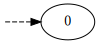

In [3]:
EPSILON = 'ε'

class EpsilonNode(AtomicNode):
    def evaluate(self):
        # Your code here!!!
        return DFA(states=1, finals=[0], transitions={})

EpsilonNode(EPSILON).evaluate()

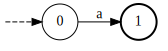

In [4]:
class SymbolNode(AtomicNode):
    def evaluate(self):
        s = self.lex
        # Your code here!!!
        return DFA(states=2, finals=[1], transitions={(0, s): 1})

SymbolNode('a').evaluate()

In [5]:
class ClosureNode(UnaryNode):
    @staticmethod
    def operate(value):
        # Your code here!!!
        return automata_closure(value)
    
ClosureNode(SymbolNode('a')).evaluate()

In [6]:
class UnionNode(BinaryNode):
    @staticmethod
    def operate(lvalue, rvalue):
        # Your code here!!!
        return automata_union(lvalue, rvalue)

UnionNode(SymbolNode('a'), SymbolNode('b')).evaluate()

In [16]:
class ConcatNode(BinaryNode):
    @staticmethod
    def operate(lvalue, rvalue):
        # Your code here!!!
        return automata_concatenation(lvalue, rvalue)

ConcatNode(SymbolNode('a'), SymbolNode('b')).evaluate()

### Gramática

Habiendo definido los nodos del AST, pasemos a diseñar la gramática atributada para construirlo. Recordemos que es necesario que la gramática no sea ambigua (para ser parseable), no tener prefijos comunes ni recursividad izquierda (para ser parseable con un parser LL(1)) y que respete la prioridad de los operadores.

In [8]:
from cmp.pycompiler import Grammar

G = Grammar()

E = G.NonTerminal('E', True)
T, F, A, X, Y, Z = G.NonTerminals('T F A X Y Z')
pipe, star, opar, cpar, symbol, epsilon = G.Terminals('| * ( ) symbol ε')

# > PRODUCTIONS???
# Your code here!!!
E %= T + X, lambda h, s: s[2], None, lambda h, s: s[1]
X %= pipe + E, lambda h, s: UnionNode(h[0], s[2])
X %= G.Epsilon, lambda h, s: h[0]
T %= F + Y, lambda h, s: s[2], None, lambda h, s: s[1]
Y %= T, lambda h, s: ConcatNode(h[0], s[1])
Y %= G.Epsilon, lambda h, s: h[0]
F %= A + Z, lambda h, s: s[2], None, lambda h, s: s[1]
Z %= star, lambda h, s: ClosureNode(h[0])
Z %= G.Epsilon, lambda h, s: h[0]
A %= symbol, lambda h, s: SymbolNode(s[1])
A %= epsilon, lambda h, s: EpsilonNode(s[1])
A %= opar + E + cpar, lambda h, s: s[2]

print(G)

Non-Terminals:
	E, T, F, A, X, Y, Z
Terminals:
	|, *, (, ), symbol, ε
Productions:
	[E -> T X, X -> | E, X -> e, T -> F Y, Y -> T, Y -> e, F -> A Z, Z -> *, Z -> e, A -> symbol, A -> ε, A -> ( E )]


### Tokenizer

Para el lexer a _pico y pala_, procederemos como de costumbre: mantendremos una colección con los tokens de lexema fijo y cualquier otro elemento será tratado como símbolo. Los lexemas no se obtendrán de separar por espacios, sino de considerar cada caracter de la cadena original como lexema.

In [9]:
from cmp.utils import Token

def regex_tokenizer(text, G, skip_whitespaces=True):
    tokens = []
    # > fixed_tokens = ???
    # Your code here!!!
    fixed_tokens = {symbol: Token(symbol, G[symbol]) for symbol in ['|', '*', '(', ')', 'ε']}
    for char in text:
        if skip_whitespaces and char.isspace():
            continue
        # Your code here!!!
        try:
            actual = fixed_tokens[char]
        except KeyError:
            actual = Token(char, G['symbol'])
        tokens.append(actual)
        
    tokens.append(Token('$', G.EOF))
    return tokens

tokens = regex_tokenizer('a*(a|b)*cd | ε',G)
tokens

[symbol: a,
 *: *,
 (: (,
 symbol: a,
 |: |,
 symbol: b,
 ): ),
 *: *,
 symbol: c,
 symbol: d,
 |: |,
 ε: ε,
 $: $]

### Parser

Usaremos un parser LL(1) para obtener un parse izquierdo de la cadena (expresión regular).

In [10]:
from cmp.tools.parsing import metodo_predictivo_no_recursivo

parser = metodo_predictivo_no_recursivo(G)
left_parse = parser(tokens)
left_parse

[E -> T X,
 T -> F Y,
 F -> A Z,
 A -> symbol,
 Z -> *,
 Y -> T,
 T -> F Y,
 F -> A Z,
 A -> ( E ),
 E -> T X,
 T -> F Y,
 F -> A Z,
 A -> symbol,
 Z -> e,
 Y -> e,
 X -> | E,
 E -> T X,
 T -> F Y,
 F -> A Z,
 A -> symbol,
 Z -> e,
 Y -> e,
 X -> e,
 Z -> *,
 Y -> T,
 T -> F Y,
 F -> A Z,
 A -> symbol,
 Z -> e,
 Y -> T,
 T -> F Y,
 F -> A Z,
 A -> symbol,
 Z -> e,
 Y -> e,
 X -> | E,
 E -> T X,
 T -> F Y,
 F -> A Z,
 A -> ε,
 Z -> e,
 Y -> e,
 X -> e]

### AST

Para obtener el AST evaluaremos los atributos de la gramática. Esto devolverá el AST sintetizado en la producción raíz de la gramática.

In [11]:
from cmp.tools.evaluation import evaluate_parse

ast = evaluate_parse(left_parse, tokens)
print(printer(ast))

\__<expr> UnionNode <expr>
	\__<expr> ConcatNode <expr>
		\__<expr> ClosureNode
			\__ SymbolNode: a
		\__<expr> ConcatNode <expr>
			\__<expr> ClosureNode
				\__<expr> UnionNode <expr>
					\__ SymbolNode: a
					\__ SymbolNode: b
			\__<expr> ConcatNode <expr>
				\__ SymbolNode: c
				\__ SymbolNode: d
	\__ EpsilonNode: ε


### Autómata

Y para obtener el autómata simplemente invocamos el método `evaluate` de la raíz del AST.

In [12]:
nfa = ast.evaluate()
nfa

Convirtámoslo ahora en DFA para comprobar que reconoce las cadenas del lenguaje denotado por la expresión regular.

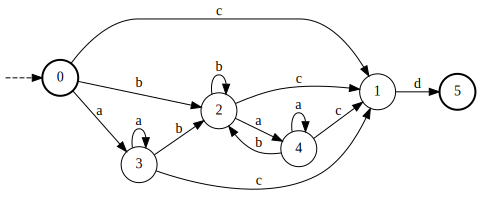

In [13]:
dfa = nfa_to_dfa(nfa)
display(dfa)

assert dfa.recognize('')
assert dfa.recognize('cd')
assert dfa.recognize('aaaaacd')
assert dfa.recognize('bbbbbcd')
assert dfa.recognize('bbabababcd')
assert dfa.recognize('aaabbabababcd')

assert not dfa.recognize('cda')
assert not dfa.recognize('aaaaa')
assert not dfa.recognize('bbbbb')
assert not dfa.recognize('ababba')
assert not dfa.recognize('cdbaba')
assert not dfa.recognize('cababad')
assert not dfa.recognize('bababacc')

Finalmente, aplicaremos el algoritmo de minimización de autómatas para obtener una versión más compacta del mismo.

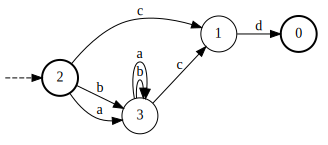

In [14]:
mini = automata_minimization(dfa)
display(mini)

## Propuestas

- Implemente un intérprete para _expresiones regulares extendidas_ (operadores: `+`, `?`, `[ ]`, etc)